In [1]:
!screenfetch

                          ./+o+-       ivb@cds2
                  yyyyy- -yyyyyy+      OS: Ubuntu 18.04 bionic
               ://+//////-yyyyyyo      Kernel: x86_64 Linux 4.15.0-74-generic
           .++ .:/++++++/-.+sss/`      Uptime: 2d 10h 19m
         .:++o:  /++++++++/:--:/-      Packages: 3045
        o:+o+:++.`..```.-/oo+++++/     Shell: sh
       .:+o:+o/.          `+sssoo+/    CPU: Intel Xeon Gold 6154 @ 16x 3GHz
  .++/+:+oo+o:`             /sssooo.   GPU: Tesla V100-SXM2-32GB, Tesla V100-SXM2-32GB, Tesla V100-SXM2-32GB, Tesla V100-SXM2-32GB
 /+++//+:`oo+o               /::--:.   RAM: 27166MiB / 128933MiB
 \+/+o+++`o++o               ++////.  
  .++.o+++oo+:`             /dddhhh.  
       .+.o+oo:.          `oddhhhh+   
        \+.++o+o``-````.:ohdhhhhh+    
         `:o+++ `ohhhhhhhhyo++os:     
           .o:`.syhhhhhhh/.oo++o`     
               /osyyyyyyo++ooo+++/    
                   ````` +oo+++o\:    
                          `oo++.      


In [2]:
# x -50 50
# y 0 50
# z 0 200

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import numpy as np
import json
import config as C
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from utils import parse_camera_intrinsic as parse_camera_intrinsic
from scipy.spatial.transform import Rotation as R
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms as T
from torch import nn
from tqdm import tqdm
import seaborn

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [6]:
with open(C.TRAIN_CROPS_JSON, "r") as f:
    train_gt = json.load(f)

In [7]:
train_gt["annotations"][0]

{'id': 1,
 'image_id': 0,
 'category_id': 47,
 'bbox': [1723.0, 1776.0, 29.0, 26.0],
 'position': [3.8249, 31.7701, 168.57],
 'orientation': [0.0063812, -0.184722, 3.13912],
 'orientation_relative': [0.006918107352997232,
  -0.18451171371342667,
  3.139121365067781]}

In [8]:
p = parse_camera_intrinsic()
for k in p:
    p[k] = torch.from_numpy(np.array(p[k],dtype=np.float))

In [9]:
import io
class PKURegressionDataset(Dataset):
    
    def __init__(self, orientation_field, images_dir, whole_images_dir, max_size, max_whole_size, transforms=None):
        super().__init__()
        self.orientation_field = orientation_field
        self.images_dir = images_dir
        self.whole_images_dir = whole_images_dir
        self.max_size = max_size
        self.max_whole_size = max_whole_size
        self.transforms = transforms
        
        with open(C.TRAIN_CROPS_JSON, "r") as f:
            self.gt = json.load(f)
        
        annotations =[]
        for i in range(len(self.gt['annotations'])):
            wx, wy, wz = self.gt['annotations'][i]['position']
            if ((-50<wx<50) and (0<wy<50) and (0<wz<200) and (np.sqrt(wx**2 + wy**2 +wz**2) < 100)):
                annotations.append(self.gt['annotations'][i])
        self.gt['annotations'] = annotations
    
        cat_ids = set(ann['category_id'] for ann in self.gt['annotations'])
        categories = [cat for cat in self.gt['categories'] if cat['id'] in cat_ids]
        self.category_id_to_label = {
            cat["id"]: label
            for label, cat in enumerate(sorted(categories, key=lambda x: x["id"]))
        }
        self.images_jpeg = self.load_images()
        self.whole_images_jpeg, self.ann_id_to_whole_image_filename = self.load_whole_images()
        
        self.p = parse_camera_intrinsic()
        for k in self.p:
            self.p[k] = float(self.p[k])
    
    def load_images(self):
        images = {}
        for image in tqdm(self.gt['images']):
            path = os.path.join(self.images_dir, image['file_name'])
            data = open(path, 'rb').read()
            images[image['id']] = io.BytesIO(data)
        return images
    
    def load_whole_images(self):
        ann_id_to_whole_image_filename = {}
        filenames = []
        for image in self.gt['images']:
            name, ext = image['file_name'].split('.')
            ID, whole_image_name, ann_id = name.split("_")
            whole_image_name = ID + "_" + whole_image_name
            filename = whole_image_name + '.' + ext
            ann_id_to_whole_image_filename[int(ann_id)] = filename
            filenames.append(filename)
        filenames = list(set(filenames))
        whole_images_jpeg = {}
        for filename in tqdm(filenames):
            path = os.path.join(self.whole_images_dir, filename)
            data = open(path, 'rb').read()
            whole_images_jpeg[filename] = io.BytesIO(data)
        return whole_images_jpeg, ann_id_to_whole_image_filename, 
    
    def __len__(self):
        return len(self.gt["annotations"])
    
    def __getitem__(self, idx):
        image = self.load_image(idx)
        whole_image = self.load_whole_image(idx)
        label = self.get_label(idx)
        bbox_x, bbox_y, bbox_w, bbox_h = self.get_bbox(idx)
        bbox_center_x, bbox_center_y = bbox_x + bbox_w / 2, bbox_y + bbox_h / 2
        wx, wy, wz = self.get_position(idx)
        orientation = self.get_orientation(idx)
        
        result =  dict(
            image=image,
            whole_image=whole_image,
            label=label,
            bbox=np.array([(bbox_center_x-self.p['cx'])/self.p['fx'], (bbox_center_y-self.p['cy'])/self.p['fy'], bbox_w/self.p['fx'], bbox_h/self.p['fy']]),
            position=np.array([wx, wy, wz]),
            distance=np.sqrt(wx**2 + wy**2 + wz**2),
            orientation=np.array(orientation)
            )
        if self.transforms is not None:
            result['image'] = self.transforms(result['image'])
            result['whole_image'] = self.transforms(result['whole_image'])
        return result
    
    def load_image(self, idx):
        image_id = self.gt["annotations"][idx]["image_id"]
        image = self.decode_image(self.images_jpeg[image_id])
        w, h = image.size
        scale = self.max_size / max(w, h)
        w_new, h_new = int(w * scale), int(h * scale)
        image = image.resize((w_new, h_new), Image.LANCZOS)
        new_image = Image.new("RGB", (self.max_size, self.max_size))
        new_image.paste(image, ((self.max_size - w_new) // 2, (self.max_size - h_new) // 2))
        return new_image

    def load_whole_image(self, idx):
        ann_id = self.gt["annotations"][idx]["id"]
        image = self.decode_image(self.whole_images_jpeg[self.ann_id_to_whole_image_filename[ann_id]])
        w, h = image.size
        scale = self.max_whole_size / max(w, h)
        w_new, h_new = int(w * scale), int(h * scale)
        image = image.resize((w_new, h_new), Image.LANCZOS)
        new_image = Image.new("RGB", (self.max_whole_size, self.max_whole_size))
        new_image.paste(image, ((self.max_whole_size - w_new) // 2, (self.max_whole_size - h_new) // 2))
        return new_image

    @staticmethod
    def decode_image(bytes_io):
        image = Image.open(bytes_io)
        image.load()
        return image
        
    def get_label(self, idx):
        return self.category_id_to_label[self.gt["annotations"][idx]["category_id"]]
    
    def get_bbox(self, idx):
        return self.gt["annotations"][idx]["bbox"]
    
    def get_position(self, idx):
        return self.gt["annotations"][idx]["position"]
    
    def get_orientation(self, idx):
        euler_angles = -1*np.array(self.gt["annotations"][idx][self.orientation_field])
        prom = euler_angles[0]*1
        euler_angles[0] = euler_angles[1]*1
        euler_angles[1] = prom*1
        rotation = R.from_euler("YXZ", euler_angles)
        q = rotation.as_quat()
        e = np.array([0,0,1])
        q[:3] = q[:3] * np.dot(e, q[:3]) / (np.abs(np.dot(q[:3], e)))
        return q

In [10]:
transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [11]:
ds = PKURegressionDataset("orientation_relative", C.TRAIN_CROPS_CALIBRATED, C.TRAIN_IMAGES, 256, 512, transforms)

100%|██████████| 4219/4219 [00:02<00:00, 1942.83it/s]


In [12]:
len(ds)

44277

In [13]:
r = ds[2]

In [14]:
r["image"].shape

torch.Size([3, 256, 256])

In [15]:
r["whole_image"].shape

torch.Size([3, 512, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


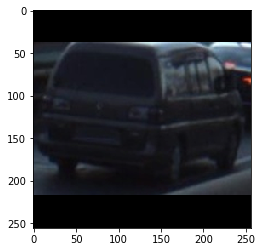

In [16]:
plt.imshow((np.transpose(r["image"].numpy(), (1, 2, 0)) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


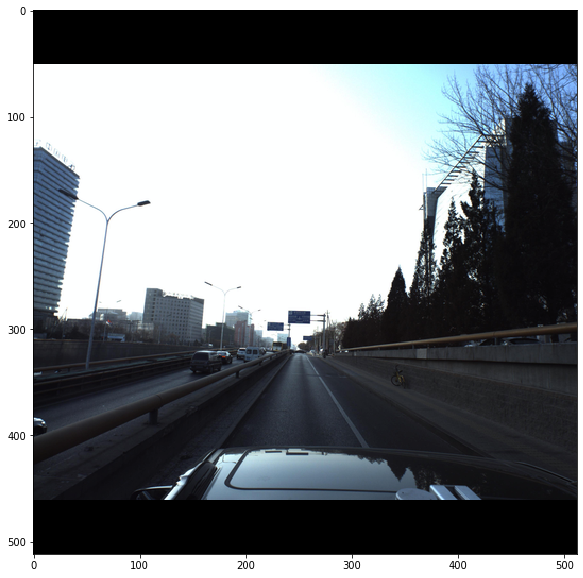

In [17]:
plt.figure(figsize=[15, 10])
plt.imshow((np.transpose(r["whole_image"].numpy(), (1, 2, 0)) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])))

In [18]:
r

{'image': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044,

In [19]:
batch_size = 32

In [20]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)

In [21]:
for batch in dl:
    break

print(batch)

In [22]:
len(ds.category_id_to_label)

34

In [23]:
batch['image'].shape

torch.Size([32, 3, 256, 256])

In [24]:
rad_power = 6

In [25]:
class ConvBnAct(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, (3, 3), padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(inplace=True)
        
        nn.init.kaiming_normal_(self.conv.weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.conv.bias, 0)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class Model(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet101(pretrained=True)
        self.big_backbone = models.resnet101(pretrained=True)
        
        self.local_neck = nn.Sequential(
            ConvBnAct(2048, 512),
            ConvBnAct(512, 256),
            ConvBnAct(256, 64),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 1024),  # 4
            nn.LeakyReLU(inplace=True),
            nn.Linear(1024, 1024),  # 6
            nn.LeakyReLU(inplace=True)
        )
        nn.init.kaiming_normal_(self.local_neck[4].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.local_neck[4].bias, 0)
        nn.init.kaiming_normal_(self.local_neck[6].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.local_neck[6].bias, 0)
        
        self.cls_head = nn.Linear(1024, 34)
        nn.init.kaiming_normal_(self.cls_head.weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.cls_head.bias, 0)
        
        self.rot_head = nn.Linear(1024, 4)
        nn.init.kaiming_normal_(self.rot_head.weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.rot_head.bias, 0)
        
#         self.trans_ass = nn.Sequential(
#             nn.Linear(rad_power,1,bias=False)    
#         )
#         nn.init.xavier_normal_(self.trans_ass[0].weight)
        
        
        self.trans_neck = nn.Sequential(
             nn.Linear(1024, 128),  # 0
             nn.LeakyReLU(inplace=True)#,
        )
        nn.init.kaiming_normal_(self.trans_neck[0].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.trans_neck[0].bias, 0)

        self.size_neck = nn.Sequential(
            nn.Linear(4,128),
            nn.LeakyReLU(inplace=True),
            nn.Linear(128,128),
            nn.LeakyReLU(inplace=True),
            nn.Linear(128,128),
            nn.LeakyReLU(inplace=True)
        )
        nn.init.kaiming_normal_(self.size_neck[0].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.size_neck[0].bias, 0)
        nn.init.kaiming_normal_(self.size_neck[2].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.size_neck[2].bias, 0)
        nn.init.kaiming_normal_(self.size_neck[4].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.size_neck[4].bias, 0)
    
        self.trans_head = nn.Sequential(
            nn.Linear(384, 128),
            nn.LeakyReLU(inplace=True),
            nn.Linear(128,128),
            nn.LeakyReLU(inplace=True),
            nn.Linear(128,1),
        )
        nn.init.kaiming_normal_(self.trans_head[0].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.trans_head[0].bias, 0)
        nn.init.kaiming_normal_(self.trans_head[2].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.trans_head[2].bias, 0)
        nn.init.kaiming_normal_(self.trans_head[4].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.trans_head[4].bias, 0)
        
        self.no_so_local_neck = nn.Sequential(
            ConvBnAct(2048, 1024),
            ConvBnAct(1024, 512),
            ConvBnAct(512, 256),
            ConvBnAct(256, 64),
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 1024),
            nn.LeakyReLU(inplace=True),
            nn.Linear(1024, 1024),  
            nn.LeakyReLU(inplace=True),
            nn.Linear(1024, 128),  
            nn.LeakyReLU(inplace=True)

        )
        nn.init.kaiming_normal_(self.no_so_local_neck[5].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.no_so_local_neck[5].bias, 0)
        nn.init.kaiming_normal_(self.no_so_local_neck[7].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.no_so_local_neck[7].bias, 0)
        nn.init.kaiming_normal_(self.no_so_local_neck[9].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.no_so_local_neck[9].bias, 0)
        
        
    def extract_features(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        return x
    
    def extract_nl_features(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        return x
    
    def forward(self, x,bbox,whole_image):
        
        features = self.extract_features(x)
        nl_features = self.extract_nl_features(whole_image)
        #print(nl_features.shape)
        
        nln= self.no_so_local_neck(nl_features)
        ln = self.local_neck(features)
        
        tn = self.trans_neck(ln)
        
#         rad = torch.sqrt(torch.pow(bbox[:,0:1],2) + torch.pow(bbox[:,1:2],2))
#         rad_powers = rad
#         for i in range(1,rad_power):
#             rad_powers = torch.cat((rad_powers,torch.pow(rad,i+1)),dim=-1 )
            
#         ta = 1 + self.trans_ass(rad_powers)
                            
        
        sn = self.size_neck(bbox)
        
        distance = self.trans_head(torch.cat((sn,tn,nln),dim = -1))
        
        distance_scaled = distance*1 #ta
        
        cls_score = self.cls_head(ln)
        orientation = self.rot_head(ln)
        
        return dict(cls_score=cls_score, orientation = orientation, distance = distance_scaled)

In [26]:
model = Model()

for p in model.big_backbone.parameters():
    p.requires_grad = False

In [27]:
sum(p.nelement() for p in model.parameters())

148264439

In [28]:
#sum(p.nelement() for p in model.backbone.parameters())

outputs = model(batch['image'])

outputs

 torch.norm(outputs['orientation'], dim=-1, keepdim=True)

In [29]:
def huber_loss(bbox_pred, bbox_targets, beta=2.8):
    """
    SmoothL1(x) = 0.5 * x^2 / beta      if |x| < beta
                  |x| - 0.5 * beta      otherwise.
    https://en.wikipedia.org/wiki/Huber_loss
    """
    box_diff = bbox_pred - bbox_targets

    dis_trans = torch.norm(box_diff, dim=1)
    # dis_trans = np.linalg.norm(box_diff.data.cpu().numpy(), axis=1)
    # we also add a metric for dist<2.8 metres.
    inbox_idx = dis_trans <= 2.8
    outbox_idx = dis_trans > 2.8

    # bbox_inside_weights = torch.from_numpy(inbox_idx.astype('float32')).cuda()
    # bbox_outside_weights = torch.from_numpy(outbox_idx.astype('float32')).cuda()
    bbox_inside_weights = inbox_idx.float()
    bbox_outside_weights = outbox_idx.float()

    in_box_pow_diff = 0.5 * torch.pow(box_diff, 2) / beta
    in_box_loss = in_box_pow_diff.sum(dim=1) * bbox_inside_weights

    out_box_abs_diff = torch.abs(box_diff)
    out_box_loss = (out_box_abs_diff.sum(dim=1) - beta / 2) * bbox_outside_weights

    loss_box = in_box_loss + out_box_loss
    N = loss_box.size(0)  # batch size
    loss_box = loss_box.view(-1).sum(0) / N
    return loss_box

In [30]:
def dist_to_coord(outputs, batch):
#     print(outputs['distance'])
    z_outputs = outputs['distance']*torch.sqrt(1/torch.reshape(1+torch.pow(batch['bbox'][:,0],2)+torch.pow(batch['bbox'][:,1],2),(batch_size,1)))
    x_outputs = torch.reshape(batch['bbox'][:,0],(batch_size,1))*z_outputs
    y_outputs = torch.reshape(batch['bbox'][:,1],(batch_size,1))*z_outputs
#     print(torch.cat((x_outputs,y_outputs,z_outputs),dim = -1))
    return torch.cat((x_outputs,y_outputs,z_outputs),dim = -1)

def dist_to_coord(outputs, batch):
#     print(outputs['distance'])
    z_outputs = outputs['distance']*torch.sqrt(1/torch.reshape(1+torch.pow((batch['bbox'][:,0]-p['cx'])/p['fx'],2)+torch.pow((batch['bbox'][:,1]-p['cy'])/p['fy'],2),(64,1)))
    x_outputs = torch.reshape((batch['bbox'][:,0]-p['cx'])/p['fx'],(64,1))*z_outputs
    y_outputs = torch.reshape((batch['bbox'][:,1]-p['cy'])/p['fy'],(64,1))*z_outputs
#     print(torch.cat((x_outputs,y_outputs,z_outputs),dim = -1))
    return torch.cat((x_outputs,y_outputs,z_outputs),dim = -1)

In [31]:
def mean_distance(batch,outputs):
    dist_to_coord(outputs,batch),batch['position']
    distance = torch.sqrt(torch.pow((dist_to_coord(outputs,batch)-batch['position']),2).sum(dim=1)).mean()
    return distance

In [32]:
def loss_fn(outputs, batch):
    cls_loss = nn.functional.cross_entropy(outputs['cls_score'], batch['label'])
    normed = outputs['orientation'] / torch.norm(outputs['orientation'], dim=-1, keepdim=True)
    
#     e = torch.FloatTensor([0, 0, 1]).cuda()
#     prod = (normed[:, :3] * e).sum(dim=1)
#     normed2 = torch.cat((torch.unsqueeze(prod / torch.abs(prod), 1) * normed[:, :3], normed[:, 3:4]), dim=1)
#     trans_loss = huber_loss(outputs['translation'],batch['position'])

    rot_loss_old = nn.functional.l1_loss(normed, batch['orientation'])
    
    rot_loss = 1-(normed[:, -1] * batch['orientation'][:, -1] + \
               (normed[:, :-1] * batch['orientation'][:, :-1]).sum(dim=1)).mean()
    trans_loss = huber_loss(dist_to_coord(outputs,batch),batch['position'])
#     distance_loss = huber_loss(outputs['distance'],batch['distance'])
    true_distance = mean_distance(batch,outputs)
    loss =  rot_loss + 0.1*trans_loss + cls_loss 
    return dict(loss=loss, cls_loss=rot_loss_old, rot_loss = rot_loss, trans_loss = trans_loss, true_distance = true_distance)

In [33]:
model = model.cuda()

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

sd = optimizer.state_dict()
sd['param_groups'][0]['lr'] = sd['param_groups'][0]['lr']/2
optimizer.load_state_dict(sd)

sd['param_groups'][0]['lr']

model.load_state_dict(torch.load("model_16-01-16:35.pth"))
optimizer.load_state_dict(torch.load("optim_16-01-16:35.pth"))

In [35]:
losses = []

In [36]:
pbar = tqdm(total=len(dl))

  0%|          | 0/1383 [00:00<?, ?it/s]

In [37]:
def smooth(beta, array):
    s=[]
    s.append(array[0])
    for i in range(1,len(array)):
        s.append((1-beta)*s[-1]+beta*array[i])
    return s

In [38]:
from IPython.display import clear_output

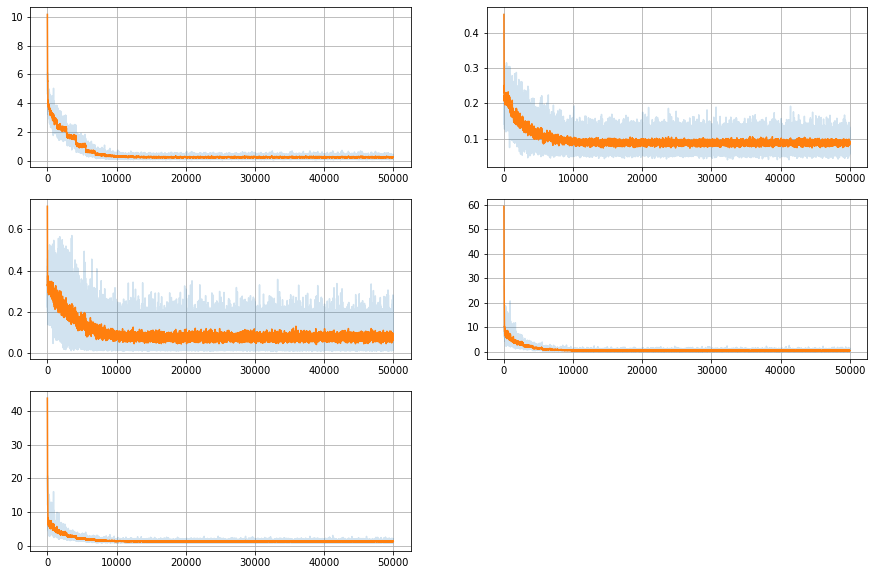

0.29592 0.07099 0.07376 0.46282 1.19820: : 50187it [14:43:14,  1.08s/it]

KeyboardInterrupt: 

In [39]:
#pbar = tqdm(total=len(dl))
for i in range(100):
    for j, batch in enumerate(dl):
        for k in batch:
            if k == 'label':
                batch[k] = batch[k].long()
            else:
                batch[k] = batch[k].float()
            batch[k] = batch[k].cuda()
        outputs = model(batch['image'],batch['bbox'],batch['whole_image'])
        loss = loss_fn(outputs, batch)
        optimizer.zero_grad()
        loss['loss'].backward()
        optimizer.step()
        for k in loss:
            loss[k] = loss[k].item()
        losses.append(loss)
        pbar.update()
        pbar.set_description("{:.5f} {:.5f} {:.5f} {:.5f} {:.5f}".format(loss['loss'], loss['cls_loss'], loss['rot_loss'], loss['trans_loss'], loss['true_distance']))
        if j % 200 == 0:
            clear_output()
            plt.figure(figsize=[15, 10])
            plt.subplot(3, 2, 1)
            plt.plot([l["loss"] for l in losses], alpha=0.2) #second epoch lr =1e-4
            plt.plot(smooth(0.1, [l["loss"] for l in losses]))
            #plt.ylim((0,3))
            plt.grid()
            plt.subplot(3, 2, 2)
            plt.plot([l["cls_loss"] for l in losses], alpha=0.2) #second epoch lr =1e-4
            plt.plot(smooth(0.1, [l["cls_loss"] for l in losses]))
            #plt.ylim((0,0.2))
            plt.grid()
            plt.subplot(3, 2, 3)
            plt.plot([l["rot_loss"] for l in losses], alpha=0.2) #second epoch lr =1e-4
            plt.plot(smooth(0.1, [l["rot_loss"] for l in losses]))
            #plt.ylim((0,0.4))
            plt.grid()
            plt.subplot(3, 2, 4)
            plt.plot([l["trans_loss"] for l in losses], alpha=0.2) #second epoch lr =1e-4
            plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
            #plt.ylim((0,4))
            plt.grid()
            plt.subplot(3, 2, 5)
            plt.plot([l["true_distance"] for l in losses if 'true_distance' in l], alpha=0.2) #second epoch lr =1e-4
            plt.plot(smooth(0.1, [l["true_distance"] for l in losses if 'true_distance' in l]))
            #plt.ylim((0,4))
            plt.grid()
            plt.show()
    sd = optimizer.state_dict()
    sd['param_groups'][0]['lr'] = sd['param_groups'][0]['lr']/2
    optimizer.load_state_dict(sd)

model.load_state_dict(torch.load("stupid_1501_model.pth"))

In [ ]:
%autoreload 0

torch.save(model.state_dict(), "model_16-01-17:30.pth") 
torch.save(optimizer.state_dict(), "optim_16-01-17:30.pth")

model.load_state_dict(torch.load("model_16-01-11:11.pth"))

In [41]:
pbar = tqdm(total=len(dl))
s = 0
for batch in dl:
    for k in batch:
        if k == 'label':
            batch[k] = batch[k].long()
        else:
            batch[k] = batch[k].float()
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(batch['image'],batch['bbox'],batch['whole_image'])
    dis_trans = torch.norm(batch['position'] - dist_to_coord(outputs,batch), dim=1)
    s += (dis_trans < 0.1).long().sum().item()
    pbar.update()
print(s / len(ds))



  0%|          | 0/1383 [00:00<?, ?it/s]

  0%|          | 1/1383 [00:03<1:22:13,  3.57s/it]

  0%|          | 2/1383 [00:03<59:50,  2.60s/it]  

  0%|          | 3/1383 [00:05<55:05,  2.39s/it]

  0%|          | 4/1383 [00:06<40:44,  1.77s/it]

  0%|          | 5/1383 [00:08<43:46,  1.91s/it]

  0%|          | 6/1383 [00:08<32:51,  1.43s/it]

  1%|          | 7/1383 [00:10<36:24,  1.59s/it]

  1%|          | 8/1383 [00:10<27:40,  1.21s/it]

  1%|          | 9/1383 [00:12<33:11,  1.45s/it]

  1%|          | 10/1383 [00:13<25:24,  1.11s/it]

  1%|          | 11/1383 [00:15<31:57,  1.40s/it]

  1%|          | 12/1383 [00:15<24:33,  1.07s/it]

  1%|          | 13/1383 [00:17<31:35,  1.38s/it]

  1%|          | 14/1383 [00:18<24:17,  1.06s/it]

  1%|          | 15/1383 [00:20<31:02,  1.36s/it]

  1%|          | 16/1383 [00:20<23:54,  1.05s/it]

  1%|          | 17/1383 [00:22<30:20,  1.33s/it]

  1%|▏         | 18/1383 [00:22<23:25,  1.03s/it]

  1%|▏         | 19/1383 [00:24<29:50,  1.3

 10%|█         | 143/1383 [02:47<26:16,  1.27s/it]

 10%|█         | 144/1383 [02:48<25:03,  1.21s/it]

 10%|█         | 145/1383 [02:50<27:10,  1.32s/it]

 11%|█         | 146/1383 [02:50<23:23,  1.13s/it]

 11%|█         | 147/1383 [02:52<25:03,  1.22s/it]

 11%|█         | 148/1383 [02:53<21:50,  1.06s/it]

 11%|█         | 149/1383 [02:54<23:07,  1.12s/it]

 11%|█         | 150/1383 [02:55<22:03,  1.07s/it]

 11%|█         | 151/1383 [02:56<21:04,  1.03s/it]

 11%|█         | 152/1383 [02:57<23:54,  1.17s/it]

 11%|█         | 153/1383 [02:58<22:39,  1.11s/it]

 11%|█         | 154/1383 [03:00<25:02,  1.22s/it]

 11%|█         | 155/1383 [03:00<22:05,  1.08s/it]

 11%|█▏        | 156/1383 [03:02<24:37,  1.20s/it]

 11%|█▏        | 157/1383 [03:03<21:50,  1.07s/it]

 11%|█▏        | 158/1383 [03:04<23:17,  1.14s/it]

 11%|█▏        | 159/1383 [03:05<22:33,  1.11s/it]

 12%|█▏        | 160/1383 [03:06<21:26,  1.05s/it]

 12%|█▏        | 161/1383 [03:07<21:58,  1.08s/it]

 12%|█▏     

 21%|██        | 284/1383 [06:11<38:47,  2.12s/it]

 21%|██        | 285/1383 [06:12<28:57,  1.58s/it]

 21%|██        | 286/1383 [06:15<37:59,  2.08s/it]

 21%|██        | 287/1383 [06:15<28:26,  1.56s/it]

 21%|██        | 288/1383 [06:19<38:17,  2.10s/it]

 21%|██        | 289/1383 [06:19<28:35,  1.57s/it]

 21%|██        | 290/1383 [06:22<39:18,  2.16s/it]

 21%|██        | 291/1383 [06:23<29:15,  1.61s/it]

 21%|██        | 292/1383 [06:26<39:41,  2.18s/it]

 21%|██        | 293/1383 [06:27<29:31,  1.63s/it]

 21%|██▏       | 294/1383 [06:30<39:08,  2.16s/it]

 21%|██▏       | 295/1383 [06:30<29:16,  1.61s/it]

 21%|██▏       | 296/1383 [06:34<40:02,  2.21s/it]

 21%|██▏       | 297/1383 [06:34<29:56,  1.65s/it]

 22%|██▏       | 298/1383 [06:38<38:55,  2.15s/it]

 22%|██▏       | 299/1383 [06:38<28:57,  1.60s/it]

 22%|██▏       | 300/1383 [06:41<38:35,  2.14s/it]

 22%|██▏       | 301/1383 [06:42<28:44,  1.59s/it]

 22%|██▏       | 302/1383 [06:44<35:05,  1.95s/it]

 22%|██▏    

 31%|███       | 425/1383 [10:27<19:01,  1.19s/it]

 31%|███       | 426/1383 [10:30<25:50,  1.62s/it]

 31%|███       | 427/1383 [10:30<19:37,  1.23s/it]

 31%|███       | 428/1383 [10:33<29:49,  1.87s/it]

 31%|███       | 429/1383 [10:34<22:25,  1.41s/it]

 31%|███       | 430/1383 [10:36<29:20,  1.85s/it]

 31%|███       | 431/1383 [10:37<22:06,  1.39s/it]

 31%|███       | 432/1383 [10:39<26:52,  1.70s/it]

 31%|███▏      | 433/1383 [10:40<20:26,  1.29s/it]

 31%|███▏      | 434/1383 [10:42<25:54,  1.64s/it]

 31%|███▏      | 435/1383 [10:46<36:08,  2.29s/it]

 32%|███▏      | 436/1383 [10:47<30:58,  1.96s/it]

 32%|███▏      | 437/1383 [10:49<31:42,  2.01s/it]

 32%|███▏      | 438/1383 [10:52<35:39,  2.26s/it]

 32%|███▏      | 439/1383 [10:54<34:46,  2.21s/it]

 32%|███▏      | 440/1383 [10:56<33:37,  2.14s/it]

 32%|███▏      | 441/1383 [11:00<40:20,  2.57s/it]

 32%|███▏      | 442/1383 [11:00<29:53,  1.91s/it]

 32%|███▏      | 443/1383 [11:05<43:15,  2.76s/it]

 32%|███▏   

 41%|████      | 566/1383 [15:52<33:23,  2.45s/it]

 41%|████      | 567/1383 [15:57<42:30,  3.13s/it]

 41%|████      | 568/1383 [15:57<31:01,  2.28s/it]

 41%|████      | 569/1383 [16:01<37:45,  2.78s/it]

 41%|████      | 570/1383 [16:01<27:44,  2.05s/it]

 41%|████▏     | 571/1383 [16:05<36:26,  2.69s/it]

 41%|████▏     | 572/1383 [16:06<26:52,  1.99s/it]

 41%|████▏     | 573/1383 [16:11<41:16,  3.06s/it]

 42%|████▏     | 574/1383 [16:12<30:14,  2.24s/it]

 42%|████▏     | 575/1383 [16:16<39:57,  2.97s/it]

 42%|████▏     | 576/1383 [16:17<29:18,  2.18s/it]

 42%|████▏     | 577/1383 [16:21<38:08,  2.84s/it]

 42%|████▏     | 578/1383 [16:21<28:03,  2.09s/it]

 42%|████▏     | 579/1383 [16:27<41:15,  3.08s/it]

 42%|████▏     | 580/1383 [16:27<30:10,  2.26s/it]

 42%|████▏     | 581/1383 [16:31<38:47,  2.90s/it]

 42%|████▏     | 582/1383 [16:32<28:27,  2.13s/it]

 42%|████▏     | 583/1383 [16:36<37:48,  2.84s/it]

 42%|████▏     | 584/1383 [16:37<27:47,  2.09s/it]

 42%|████▏  

 51%|█████     | 707/1383 [20:31<17:38,  1.57s/it]

 51%|█████     | 708/1383 [20:32<15:32,  1.38s/it]

 51%|█████▏    | 709/1383 [20:35<19:16,  1.72s/it]

 51%|█████▏    | 710/1383 [20:35<15:53,  1.42s/it]

 51%|█████▏    | 711/1383 [20:37<17:37,  1.57s/it]

 51%|█████▏    | 712/1383 [20:38<15:54,  1.42s/it]

 52%|█████▏    | 713/1383 [20:40<17:33,  1.57s/it]

 52%|█████▏    | 714/1383 [20:42<17:29,  1.57s/it]

 52%|█████▏    | 715/1383 [20:43<17:22,  1.56s/it]

 52%|█████▏    | 716/1383 [20:45<18:51,  1.70s/it]

 52%|█████▏    | 717/1383 [20:47<18:51,  1.70s/it]

 52%|█████▏    | 718/1383 [20:48<17:17,  1.56s/it]

 52%|█████▏    | 719/1383 [20:50<17:35,  1.59s/it]

 52%|█████▏    | 720/1383 [20:51<16:14,  1.47s/it]

 52%|█████▏    | 721/1383 [20:53<18:15,  1.66s/it]

 52%|█████▏    | 722/1383 [20:55<18:08,  1.65s/it]

 52%|█████▏    | 723/1383 [20:56<14:52,  1.35s/it]

 52%|█████▏    | 724/1383 [20:58<18:07,  1.65s/it]

 52%|█████▏    | 725/1383 [20:58<13:43,  1.25s/it]

 52%|█████▏ 

 61%|██████▏   | 848/1383 [24:14<15:14,  1.71s/it]

 61%|██████▏   | 849/1383 [24:15<12:56,  1.45s/it]

 61%|██████▏   | 850/1383 [24:17<14:55,  1.68s/it]

 62%|██████▏   | 851/1383 [24:18<13:35,  1.53s/it]

 62%|██████▏   | 852/1383 [24:21<17:42,  2.00s/it]

 62%|██████▏   | 853/1383 [24:21<13:15,  1.50s/it]

 62%|██████▏   | 854/1383 [24:24<15:24,  1.75s/it]

 62%|██████▏   | 855/1383 [24:24<12:11,  1.39s/it]

 62%|██████▏   | 856/1383 [24:27<15:17,  1.74s/it]

 62%|██████▏   | 857/1383 [24:27<11:32,  1.32s/it]

 62%|██████▏   | 858/1383 [24:30<14:23,  1.65s/it]

 62%|██████▏   | 859/1383 [24:30<11:12,  1.28s/it]

 62%|██████▏   | 860/1383 [24:32<12:24,  1.42s/it]

 62%|██████▏   | 861/1383 [24:32<10:23,  1.19s/it]

 62%|██████▏   | 862/1383 [24:35<12:56,  1.49s/it]

 62%|██████▏   | 863/1383 [24:36<12:29,  1.44s/it]

 62%|██████▏   | 864/1383 [24:39<16:31,  1.91s/it]

 63%|██████▎   | 865/1383 [24:40<13:58,  1.62s/it]

 63%|██████▎   | 866/1383 [24:42<16:04,  1.87s/it]

 63%|██████▎

 72%|███████▏  | 989/1383 [27:54<11:21,  1.73s/it]

 72%|███████▏  | 990/1383 [27:55<08:35,  1.31s/it]

 72%|███████▏  | 991/1383 [27:57<10:59,  1.68s/it]

 72%|███████▏  | 992/1383 [27:58<08:22,  1.28s/it]

 72%|███████▏  | 993/1383 [28:01<11:45,  1.81s/it]

 72%|███████▏  | 994/1383 [28:01<09:33,  1.47s/it]

 72%|███████▏  | 995/1383 [28:04<11:40,  1.81s/it]

 72%|███████▏  | 996/1383 [28:05<10:49,  1.68s/it]

 72%|███████▏  | 997/1383 [28:07<11:52,  1.85s/it]

 72%|███████▏  | 998/1383 [28:10<12:17,  1.91s/it]

 72%|███████▏  | 999/1383 [28:11<11:10,  1.75s/it]

 72%|███████▏  | 1000/1383 [28:13<11:53,  1.86s/it]

 72%|███████▏  | 1001/1383 [28:15<11:12,  1.76s/it]

 72%|███████▏  | 1002/1383 [28:17<12:16,  1.93s/it]

 73%|███████▎  | 1003/1383 [28:18<10:19,  1.63s/it]

 73%|███████▎  | 1004/1383 [28:21<13:33,  2.15s/it]

 73%|███████▎  | 1005/1383 [28:21<10:04,  1.60s/it]

 73%|███████▎  | 1006/1383 [28:24<12:17,  1.96s/it]

 73%|███████▎  | 1007/1383 [28:25<09:12,  1.47s/it]

 73%

 82%|████████▏ | 1128/1383 [31:32<04:29,  1.06s/it]

 82%|████████▏ | 1129/1383 [31:33<04:33,  1.08s/it]

 82%|████████▏ | 1130/1383 [31:34<04:56,  1.17s/it]

 82%|████████▏ | 1131/1383 [31:35<04:19,  1.03s/it]

 82%|████████▏ | 1132/1383 [31:36<04:42,  1.13s/it]

 82%|████████▏ | 1133/1383 [31:37<04:16,  1.03s/it]

 82%|████████▏ | 1134/1383 [31:38<04:26,  1.07s/it]

 82%|████████▏ | 1135/1383 [31:39<04:20,  1.05s/it]

 82%|████████▏ | 1136/1383 [31:41<04:26,  1.08s/it]

 82%|████████▏ | 1137/1383 [31:41<04:06,  1.00s/it]

 82%|████████▏ | 1138/1383 [31:43<04:20,  1.06s/it]

 82%|████████▏ | 1139/1383 [31:44<04:14,  1.04s/it]

 82%|████████▏ | 1140/1383 [31:45<04:29,  1.11s/it]

 83%|████████▎ | 1141/1383 [31:46<04:00,  1.00it/s]

 83%|████████▎ | 1142/1383 [31:47<04:26,  1.11s/it]

 83%|████████▎ | 1143/1383 [31:48<03:43,  1.07it/s]

 83%|████████▎ | 1144/1383 [31:49<04:29,  1.13s/it]

 83%|████████▎ | 1145/1383 [31:50<03:43,  1.06it/s]

 83%|████████▎ | 1146/1383 [31:51<04:24,  1.12

 92%|█████████▏| 1266/1383 [34:01<02:26,  1.25s/it]

 92%|█████████▏| 1267/1383 [34:01<01:52,  1.03it/s]

 92%|█████████▏| 1268/1383 [34:03<02:22,  1.24s/it]

 92%|█████████▏| 1269/1383 [34:03<01:49,  1.04it/s]

 92%|█████████▏| 1270/1383 [34:05<02:20,  1.24s/it]

 92%|█████████▏| 1271/1383 [34:05<01:48,  1.04it/s]

 92%|█████████▏| 1272/1383 [34:07<02:12,  1.20s/it]

 92%|█████████▏| 1273/1383 [34:07<01:42,  1.07it/s]

 92%|█████████▏| 1274/1383 [34:09<02:08,  1.18s/it]

 92%|█████████▏| 1275/1383 [34:09<01:39,  1.08it/s]

 92%|█████████▏| 1276/1383 [34:11<02:11,  1.23s/it]

 92%|█████████▏| 1277/1383 [34:12<01:41,  1.05it/s]

 92%|█████████▏| 1278/1383 [34:13<02:04,  1.19s/it]

 92%|█████████▏| 1279/1383 [34:14<01:36,  1.08it/s]

 93%|█████████▎| 1280/1383 [34:16<02:06,  1.23s/it]

 93%|█████████▎| 1281/1383 [34:16<01:37,  1.05it/s]

 93%|█████████▎| 1282/1383 [34:18<02:04,  1.23s/it]

 93%|█████████▎| 1283/1383 [34:18<01:35,  1.05it/s]

 93%|█████████▎| 1284/1383 [34:20<01:58,  1.20

0.0218849515549834


In [42]:
print(s)

969


In [44]:
pbar = tqdm(total=len(dl))
s = 0
for batch in dl:
    for k in batch:
        if k == 'label':
            batch[k] = batch[k].long()
        else:
            batch[k] = batch[k].float()
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(batch['image'],batch['bbox'],batch['whole_image'])
    dis_trans = torch.norm(batch['position'] - dist_to_coord(outputs,batch), dim=1)
    s += (dis_trans < 0.05*batch['distance']).long().sum().item()
    pbar.update()
print(s / len(ds))





  0%|          | 0/1383 [00:00<?, ?it/s]



  0%|          | 1/1383 [00:03<1:09:57,  3.04s/it]



  0%|          | 2/1383 [00:03<51:10,  2.22s/it]  



  0%|          | 3/1383 [00:05<48:15,  2.10s/it]



  0%|          | 4/1383 [00:05<35:58,  1.56s/it]



  0%|          | 5/1383 [00:07<38:27,  1.67s/it]



  0%|          | 6/1383 [00:07<29:06,  1.27s/it]



  1%|          | 7/1383 [00:09<34:45,  1.52s/it]



  1%|          | 8/1383 [00:10<26:34,  1.16s/it]



  1%|          | 9/1383 [00:12<31:20,  1.37s/it]



  1%|          | 10/1383 [00:12<24:07,  1.05s/it]



  1%|          | 11/1383 [00:14<32:07,  1.40s/it]



  1%|          | 12/1383 [00:14<24:39,  1.08s/it]



  1%|          | 13/1383 [00:16<30:00,  1.31s/it]



  1%|          | 14/1383 [00:17<23:11,  1.02s/it]



  1%|          | 15/1383 [00:18<29:07,  1.28s/it]



  1%|          | 16/1383 [00:19<22:33,  1.01it/s]



  1%|          | 17/1383 [00:21<29:15,  1.28s/it]



  1%|▏         | 18/1383 [00:21<22:38,  1.00it/s]



  1

  9%|▉         | 125/1383 [02:19<20:49,  1.01it/s]



  9%|▉         | 126/1383 [02:21<22:47,  1.09s/it]



  9%|▉         | 127/1383 [02:22<21:47,  1.04s/it]



  9%|▉         | 128/1383 [02:23<24:58,  1.19s/it]



  9%|▉         | 129/1383 [02:24<21:02,  1.01s/it]



  9%|▉         | 130/1383 [02:25<25:04,  1.20s/it]



  9%|▉         | 131/1383 [02:26<20:33,  1.01it/s]



 10%|▉         | 132/1383 [02:27<23:32,  1.13s/it]



 10%|▉         | 133/1383 [02:28<21:41,  1.04s/it]



 10%|▉         | 134/1383 [02:30<24:20,  1.17s/it]



 10%|▉         | 135/1383 [02:30<21:38,  1.04s/it]



 10%|▉         | 136/1383 [02:32<25:04,  1.21s/it]



 10%|▉         | 137/1383 [02:32<21:05,  1.02s/it]



 10%|▉         | 138/1383 [02:34<25:21,  1.22s/it]



 10%|█         | 139/1383 [02:35<23:10,  1.12s/it]



 10%|█         | 140/1383 [02:37<25:17,  1.22s/it]



 10%|█         | 141/1383 [02:37<22:04,  1.07s/it]



 10%|█         | 142/1383 [02:39<23:55,  1.16s/it]



 10%|█         | 143/1383 [0

 18%|█▊        | 249/1383 [04:35<18:15,  1.04it/s]



 18%|█▊        | 250/1383 [04:36<22:15,  1.18s/it]



 18%|█▊        | 251/1383 [04:37<17:22,  1.09it/s]



 18%|█▊        | 252/1383 [04:38<20:43,  1.10s/it]



 18%|█▊        | 253/1383 [04:39<16:18,  1.16it/s]



 18%|█▊        | 254/1383 [04:40<22:16,  1.18s/it]



 18%|█▊        | 255/1383 [04:41<17:23,  1.08it/s]



 19%|█▊        | 256/1383 [04:43<22:13,  1.18s/it]



 19%|█▊        | 257/1383 [04:43<17:21,  1.08it/s]



 19%|█▊        | 258/1383 [04:45<21:42,  1.16s/it]



 19%|█▊        | 259/1383 [04:45<17:03,  1.10it/s]



 19%|█▉        | 260/1383 [04:46<20:40,  1.10s/it]



 19%|█▉        | 261/1383 [04:47<16:17,  1.15it/s]



 19%|█▉        | 262/1383 [04:49<21:06,  1.13s/it]



 19%|█▉        | 263/1383 [04:49<16:33,  1.13it/s]



 19%|█▉        | 264/1383 [04:51<21:59,  1.18s/it]



 19%|█▉        | 265/1383 [04:51<17:15,  1.08it/s]



 19%|█▉        | 266/1383 [04:53<21:40,  1.16s/it]



 19%|█▉        | 267/1383 [0

 27%|██▋       | 373/1383 [06:52<16:16,  1.03it/s]



 27%|██▋       | 374/1383 [06:54<21:03,  1.25s/it]



 27%|██▋       | 375/1383 [06:54<16:20,  1.03it/s]



 27%|██▋       | 376/1383 [06:56<20:22,  1.21s/it]



 27%|██▋       | 377/1383 [06:57<15:51,  1.06it/s]



 27%|██▋       | 378/1383 [06:58<20:32,  1.23s/it]



 27%|██▋       | 379/1383 [06:59<15:58,  1.05it/s]



 27%|██▋       | 380/1383 [07:01<20:01,  1.20s/it]



 28%|██▊       | 381/1383 [07:01<15:37,  1.07it/s]



 28%|██▊       | 382/1383 [07:03<20:06,  1.21s/it]



 28%|██▊       | 383/1383 [07:03<15:40,  1.06it/s]



 28%|██▊       | 384/1383 [07:05<20:58,  1.26s/it]



 28%|██▊       | 385/1383 [07:05<16:15,  1.02it/s]



 28%|██▊       | 386/1383 [07:07<20:03,  1.21s/it]



 28%|██▊       | 387/1383 [07:07<15:38,  1.06it/s]



 28%|██▊       | 388/1383 [07:09<19:43,  1.19s/it]



 28%|██▊       | 389/1383 [07:09<15:23,  1.08it/s]



 28%|██▊       | 390/1383 [07:11<19:59,  1.21s/it]



 28%|██▊       | 391/1383 [0

 36%|███▌      | 497/1383 [09:09<14:56,  1.01s/it]



 36%|███▌      | 498/1383 [09:10<15:37,  1.06s/it]



 36%|███▌      | 499/1383 [09:11<15:20,  1.04s/it]



 36%|███▌      | 500/1383 [09:12<16:05,  1.09s/it]



 36%|███▌      | 501/1383 [09:13<15:12,  1.03s/it]



 36%|███▋      | 502/1383 [09:15<16:57,  1.16s/it]



 36%|███▋      | 503/1383 [09:15<15:03,  1.03s/it]



 36%|███▋      | 504/1383 [09:17<17:25,  1.19s/it]



 37%|███▋      | 505/1383 [09:17<13:59,  1.05it/s]



 37%|███▋      | 506/1383 [09:19<18:33,  1.27s/it]



 37%|███▋      | 507/1383 [09:20<14:22,  1.02it/s]



 37%|███▋      | 508/1383 [09:21<16:52,  1.16s/it]



 37%|███▋      | 509/1383 [09:22<13:12,  1.10it/s]



 37%|███▋      | 510/1383 [09:23<16:40,  1.15s/it]



 37%|███▋      | 511/1383 [09:24<13:03,  1.11it/s]



 37%|███▋      | 512/1383 [09:25<15:52,  1.09s/it]



 37%|███▋      | 513/1383 [09:25<12:29,  1.16it/s]



 37%|███▋      | 514/1383 [09:27<16:34,  1.14s/it]



 37%|███▋      | 515/1383 [0

 45%|████▍     | 621/1383 [11:25<13:44,  1.08s/it]



 45%|████▍     | 622/1383 [11:27<16:35,  1.31s/it]



 45%|████▌     | 623/1383 [11:27<12:51,  1.01s/it]



 45%|████▌     | 624/1383 [11:29<16:46,  1.33s/it]



 45%|████▌     | 625/1383 [11:29<12:56,  1.02s/it]



 45%|████▌     | 626/1383 [11:32<18:15,  1.45s/it]



 45%|████▌     | 627/1383 [11:32<13:59,  1.11s/it]



 45%|████▌     | 628/1383 [11:34<17:08,  1.36s/it]



 45%|████▌     | 629/1383 [11:34<13:11,  1.05s/it]



 46%|████▌     | 630/1383 [11:36<16:27,  1.31s/it]



 46%|████▌     | 631/1383 [11:37<12:46,  1.02s/it]



 46%|████▌     | 632/1383 [11:38<15:04,  1.20s/it]



 46%|████▌     | 633/1383 [11:39<11:44,  1.07it/s]



 46%|████▌     | 634/1383 [11:40<15:16,  1.22s/it]



 46%|████▌     | 635/1383 [11:41<11:54,  1.05it/s]



 46%|████▌     | 636/1383 [11:43<15:17,  1.23s/it]



 46%|████▌     | 637/1383 [11:43<12:00,  1.04it/s]



 46%|████▌     | 638/1383 [11:45<16:12,  1.31s/it]



 46%|████▌     | 639/1383 [1

 54%|█████▍    | 745/1383 [13:37<09:43,  1.09it/s]



 54%|█████▍    | 746/1383 [13:39<13:38,  1.28s/it]



 54%|█████▍    | 747/1383 [13:40<10:34,  1.00it/s]



 54%|█████▍    | 748/1383 [13:42<13:49,  1.31s/it]



 54%|█████▍    | 749/1383 [13:42<10:41,  1.01s/it]



 54%|█████▍    | 750/1383 [13:44<13:36,  1.29s/it]



 54%|█████▍    | 751/1383 [13:44<10:31,  1.00it/s]



 54%|█████▍    | 752/1383 [13:46<13:15,  1.26s/it]



 54%|█████▍    | 753/1383 [13:46<10:17,  1.02it/s]



 55%|█████▍    | 754/1383 [13:48<13:13,  1.26s/it]



 55%|█████▍    | 755/1383 [13:49<10:27,  1.00it/s]



 55%|█████▍    | 756/1383 [13:50<12:35,  1.21s/it]



 55%|█████▍    | 757/1383 [13:51<09:48,  1.06it/s]



 55%|█████▍    | 758/1383 [13:53<12:47,  1.23s/it]



 55%|█████▍    | 759/1383 [13:53<09:56,  1.05it/s]



 55%|█████▍    | 760/1383 [13:55<13:15,  1.28s/it]



 55%|█████▌    | 761/1383 [13:55<10:16,  1.01it/s]



 55%|█████▌    | 762/1383 [13:57<13:35,  1.31s/it]



 55%|█████▌    | 763/1383 [1

 63%|██████▎   | 869/1383 [15:55<08:26,  1.01it/s]



 63%|██████▎   | 870/1383 [15:57<10:37,  1.24s/it]



 63%|██████▎   | 871/1383 [15:57<08:14,  1.04it/s]



 63%|██████▎   | 872/1383 [15:59<11:03,  1.30s/it]



 63%|██████▎   | 873/1383 [16:00<08:32,  1.00s/it]



 63%|██████▎   | 874/1383 [16:02<10:29,  1.24s/it]



 63%|██████▎   | 875/1383 [16:02<08:09,  1.04it/s]



 63%|██████▎   | 876/1383 [16:04<10:04,  1.19s/it]



 63%|██████▎   | 877/1383 [16:04<07:51,  1.07it/s]



 63%|██████▎   | 878/1383 [16:06<09:47,  1.16s/it]



 64%|██████▎   | 879/1383 [16:06<07:38,  1.10it/s]



 64%|██████▎   | 880/1383 [16:08<09:47,  1.17s/it]



 64%|██████▎   | 881/1383 [16:08<07:38,  1.09it/s]



 64%|██████▍   | 882/1383 [16:10<09:53,  1.18s/it]



 64%|██████▍   | 883/1383 [16:10<07:42,  1.08it/s]



 64%|██████▍   | 884/1383 [16:12<09:41,  1.17s/it]



 64%|██████▍   | 885/1383 [16:12<07:34,  1.10it/s]



 64%|██████▍   | 886/1383 [16:14<09:37,  1.16s/it]



 64%|██████▍   | 887/1383 [1

 72%|███████▏  | 993/1383 [18:11<05:54,  1.10it/s]



 72%|███████▏  | 994/1383 [18:13<07:41,  1.19s/it]



 72%|███████▏  | 995/1383 [18:13<05:59,  1.08it/s]



 72%|███████▏  | 996/1383 [18:15<08:26,  1.31s/it]



 72%|███████▏  | 997/1383 [18:16<06:32,  1.02s/it]



 72%|███████▏  | 998/1383 [18:18<08:09,  1.27s/it]



 72%|███████▏  | 999/1383 [18:18<06:18,  1.01it/s]



 72%|███████▏  | 1000/1383 [18:20<08:12,  1.28s/it]



 72%|███████▏  | 1001/1383 [18:20<06:20,  1.00it/s]



 72%|███████▏  | 1002/1383 [18:22<07:49,  1.23s/it]



 73%|███████▎  | 1003/1383 [18:22<06:04,  1.04it/s]



 73%|███████▎  | 1004/1383 [18:24<07:26,  1.18s/it]



 73%|███████▎  | 1005/1383 [18:24<05:48,  1.09it/s]



 73%|███████▎  | 1006/1383 [18:26<07:11,  1.15s/it]



 73%|███████▎  | 1007/1383 [18:26<05:37,  1.11it/s]



 73%|███████▎  | 1008/1383 [18:28<06:56,  1.11s/it]



 73%|███████▎  | 1009/1383 [18:28<05:26,  1.14it/s]



 73%|███████▎  | 1010/1383 [18:30<07:02,  1.13s/it]



 73%|███████▎  | 

 81%|████████  | 1115/1383 [20:20<04:11,  1.07it/s]



 81%|████████  | 1116/1383 [20:21<05:06,  1.15s/it]



 81%|████████  | 1117/1383 [20:22<03:59,  1.11it/s]



 81%|████████  | 1118/1383 [20:24<05:19,  1.21s/it]



 81%|████████  | 1119/1383 [20:24<04:08,  1.06it/s]



 81%|████████  | 1120/1383 [20:26<05:07,  1.17s/it]



 81%|████████  | 1121/1383 [20:26<03:59,  1.09it/s]



 81%|████████  | 1122/1383 [20:28<04:54,  1.13s/it]



 81%|████████  | 1123/1383 [20:28<03:50,  1.13it/s]



 81%|████████▏ | 1124/1383 [20:30<05:08,  1.19s/it]



 81%|████████▏ | 1125/1383 [20:30<04:00,  1.07it/s]



 81%|████████▏ | 1126/1383 [20:32<05:08,  1.20s/it]



 81%|████████▏ | 1127/1383 [20:32<04:00,  1.06it/s]



 82%|████████▏ | 1128/1383 [20:34<05:04,  1.19s/it]



 82%|████████▏ | 1129/1383 [20:35<03:59,  1.06it/s]



 82%|████████▏ | 1130/1383 [20:36<04:59,  1.19s/it]



 82%|████████▏ | 1131/1383 [20:37<03:53,  1.08it/s]



 82%|████████▏ | 1132/1383 [20:39<05:06,  1.22s/it]



 82%|█████

 89%|████████▉ | 1237/1383 [22:30<02:09,  1.13it/s]



 90%|████████▉ | 1238/1383 [22:31<02:42,  1.12s/it]



 90%|████████▉ | 1239/1383 [22:32<02:06,  1.14it/s]



 90%|████████▉ | 1240/1383 [22:34<02:41,  1.13s/it]



 90%|████████▉ | 1241/1383 [22:34<02:06,  1.13it/s]



 90%|████████▉ | 1242/1383 [22:36<02:46,  1.18s/it]



 90%|████████▉ | 1243/1383 [22:36<02:09,  1.08it/s]



 90%|████████▉ | 1244/1383 [22:38<02:42,  1.17s/it]



 90%|█████████ | 1245/1383 [22:38<02:06,  1.09it/s]



 90%|█████████ | 1246/1383 [22:40<02:37,  1.15s/it]



 90%|█████████ | 1247/1383 [22:40<02:02,  1.11it/s]



 90%|█████████ | 1248/1383 [22:42<02:44,  1.22s/it]



 90%|█████████ | 1249/1383 [22:42<02:08,  1.05it/s]



 90%|█████████ | 1250/1383 [22:44<02:30,  1.14s/it]



 90%|█████████ | 1251/1383 [22:44<01:57,  1.12it/s]



 91%|█████████ | 1252/1383 [22:46<02:40,  1.23s/it]



 91%|█████████ | 1253/1383 [22:47<02:04,  1.05it/s]



 91%|█████████ | 1254/1383 [22:48<02:32,  1.18s/it]



 91%|█████

 98%|█████████▊| 1359/1383 [24:40<00:22,  1.05it/s]



 98%|█████████▊| 1360/1383 [24:42<00:26,  1.15s/it]



 98%|█████████▊| 1361/1383 [24:42<00:19,  1.11it/s]



 98%|█████████▊| 1362/1383 [24:44<00:24,  1.15s/it]



 99%|█████████▊| 1363/1383 [24:44<00:18,  1.11it/s]



 99%|█████████▊| 1364/1383 [24:46<00:22,  1.17s/it]



 99%|█████████▊| 1365/1383 [24:46<00:16,  1.10it/s]



 99%|█████████▉| 1366/1383 [24:48<00:22,  1.34s/it]



 99%|█████████▉| 1367/1383 [24:49<00:16,  1.04s/it]



 99%|█████████▉| 1368/1383 [24:50<00:18,  1.25s/it]



 99%|█████████▉| 1369/1383 [24:51<00:13,  1.03it/s]



 99%|█████████▉| 1370/1383 [24:52<00:15,  1.20s/it]



 99%|█████████▉| 1371/1383 [24:53<00:11,  1.07it/s]



 99%|█████████▉| 1372/1383 [24:55<00:13,  1.25s/it]



 99%|█████████▉| 1373/1383 [24:55<00:10,  1.01s/it]



 99%|█████████▉| 1374/1383 [24:57<00:12,  1.35s/it]



 99%|█████████▉| 1375/1383 [24:58<00:08,  1.05s/it]



 99%|█████████▉| 1376/1383 [24:59<00:08,  1.27s/it]



100%|█████

0.7999864489464056


In [45]:
print(s)

35421


In [47]:
pbar = tqdm(total=len(dl))
real_distance = []
predicted_distance = []
dcoord =[]
s=0
for batch in dl:
    for k in batch:
        if k == 'label':
            batch[k] = batch[k].long()
        else:
            batch[k] = batch[k].float()
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(batch['image'],batch['bbox'],batch['whole_image'])
    dis_trans = torch.norm(batch['position'] - dist_to_coord(outputs,batch), dim=1)
    dcoord.append((batch['position'] - dist_to_coord(outputs,batch)).detach().cpu().numpy())
    real_distance.append(batch['distance'].detach().cpu().numpy())
    predicted_distance.append(outputs['distance'].detach().cpu().numpy())
    s += (dis_trans < 0.1).long().sum().item()
    pbar.update()
print(s / len(ds))







  0%|          | 0/1383 [00:00<?, ?it/s]





  0%|          | 1/1383 [00:02<1:02:28,  2.71s/it]





  0%|          | 2/1383 [00:03<45:56,  2.00s/it]  





  0%|          | 3/1383 [00:04<44:36,  1.94s/it]





  0%|          | 4/1383 [00:05<33:25,  1.45s/it]





  0%|          | 5/1383 [00:06<33:46,  1.47s/it]





  0%|          | 6/1383 [00:07<28:26,  1.24s/it]





  1%|          | 7/1383 [00:08<30:52,  1.35s/it]





  1%|          | 8/1383 [00:09<24:04,  1.05s/it]





  1%|          | 9/1383 [00:11<32:03,  1.40s/it]





  1%|          | 10/1383 [00:11<24:39,  1.08s/it]





  1%|          | 11/1383 [00:13<31:47,  1.39s/it]





  1%|          | 12/1383 [00:14<24:27,  1.07s/it]





  1%|          | 13/1383 [00:16<28:48,  1.26s/it]





  1%|          | 14/1383 [00:16<22:20,  1.02it/s]





  1%|          | 15/1383 [00:17<26:48,  1.18s/it]





  1%|          | 16/1383 [00:18<20:56,  1.09it/s]





  1%|          | 17/1383 [00:19<25:16,  1.11s/it]





  1%|▏         | 1

  8%|▊         | 112/1383 [02:13<23:12,  1.10s/it]





  8%|▊         | 113/1383 [02:15<28:28,  1.34s/it]





  8%|▊         | 114/1383 [02:15<22:00,  1.04s/it]





  8%|▊         | 115/1383 [02:17<28:12,  1.33s/it]





  8%|▊         | 116/1383 [02:17<21:45,  1.03s/it]





  8%|▊         | 117/1383 [02:19<28:32,  1.35s/it]





  9%|▊         | 118/1383 [02:20<21:59,  1.04s/it]





  9%|▊         | 119/1383 [02:22<27:09,  1.29s/it]





  9%|▊         | 120/1383 [02:22<21:01,  1.00it/s]





  9%|▊         | 121/1383 [02:24<28:14,  1.34s/it]





  9%|▉         | 122/1383 [02:24<21:48,  1.04s/it]





  9%|▉         | 123/1383 [02:26<27:22,  1.30s/it]





  9%|▉         | 124/1383 [02:27<21:10,  1.01s/it]





  9%|▉         | 125/1383 [02:29<26:38,  1.27s/it]





  9%|▉         | 126/1383 [02:29<20:43,  1.01it/s]





  9%|▉         | 127/1383 [02:31<27:18,  1.30s/it]





  9%|▉         | 128/1383 [02:31<21:06,  1.01s/it]





  9%|▉         | 129/1383 [02:33<25:42,  1.23s/i

 16%|█▌        | 222/1383 [04:20<18:01,  1.07it/s]





 16%|█▌        | 223/1383 [04:22<23:23,  1.21s/it]





 16%|█▌        | 224/1383 [04:22<18:13,  1.06it/s]





 16%|█▋        | 225/1383 [04:24<24:09,  1.25s/it]





 16%|█▋        | 226/1383 [04:24<18:52,  1.02it/s]





 16%|█▋        | 227/1383 [04:26<24:44,  1.28s/it]





 16%|█▋        | 228/1383 [04:27<19:10,  1.00it/s]





 17%|█▋        | 229/1383 [04:29<24:07,  1.25s/it]





 17%|█▋        | 230/1383 [04:29<18:44,  1.03it/s]





 17%|█▋        | 231/1383 [04:31<23:06,  1.20s/it]





 17%|█▋        | 232/1383 [04:31<18:01,  1.06it/s]





 17%|█▋        | 233/1383 [04:32<21:34,  1.13s/it]





 17%|█▋        | 234/1383 [04:33<16:58,  1.13it/s]





 17%|█▋        | 235/1383 [04:34<20:49,  1.09s/it]





 17%|█▋        | 236/1383 [04:35<16:25,  1.16it/s]





 17%|█▋        | 237/1383 [04:37<22:30,  1.18s/it]





 17%|█▋        | 238/1383 [04:37<17:35,  1.08it/s]





 17%|█▋        | 239/1383 [04:39<23:05,  1.21s/i

 24%|██▍       | 332/1383 [06:19<21:54,  1.25s/it]





 24%|██▍       | 333/1383 [06:19<17:01,  1.03it/s]





 24%|██▍       | 334/1383 [06:21<20:43,  1.19s/it]





 24%|██▍       | 335/1383 [06:21<16:11,  1.08it/s]





 24%|██▍       | 336/1383 [06:23<22:37,  1.30s/it]





 24%|██▍       | 337/1383 [06:24<17:30,  1.00s/it]





 24%|██▍       | 338/1383 [06:25<21:22,  1.23s/it]





 25%|██▍       | 339/1383 [06:26<16:38,  1.05it/s]





 25%|██▍       | 340/1383 [06:27<21:05,  1.21s/it]





 25%|██▍       | 341/1383 [06:28<16:26,  1.06it/s]





 25%|██▍       | 342/1383 [06:29<20:12,  1.16s/it]





 25%|██▍       | 343/1383 [06:30<15:48,  1.10it/s]





 25%|██▍       | 344/1383 [06:32<21:30,  1.24s/it]





 25%|██▍       | 345/1383 [06:32<16:43,  1.03it/s]





 25%|██▌       | 346/1383 [06:34<21:50,  1.26s/it]





 25%|██▌       | 347/1383 [06:34<16:57,  1.02it/s]





 25%|██▌       | 348/1383 [06:37<23:11,  1.34s/it]





 25%|██▌       | 349/1383 [06:37<17:53,  1.04s/i

 32%|███▏      | 442/1383 [08:24<18:00,  1.15s/it]





 32%|███▏      | 443/1383 [08:24<14:07,  1.11it/s]





 32%|███▏      | 444/1383 [08:26<18:29,  1.18s/it]





 32%|███▏      | 445/1383 [08:26<14:27,  1.08it/s]





 32%|███▏      | 446/1383 [08:28<19:22,  1.24s/it]





 32%|███▏      | 447/1383 [08:28<15:03,  1.04it/s]





 32%|███▏      | 448/1383 [08:30<17:37,  1.13s/it]





 32%|███▏      | 449/1383 [08:30<13:50,  1.12it/s]





 33%|███▎      | 450/1383 [08:32<17:09,  1.10s/it]





 33%|███▎      | 451/1383 [08:32<13:30,  1.15it/s]





 33%|███▎      | 452/1383 [08:34<17:04,  1.10s/it]





 33%|███▎      | 453/1383 [08:34<13:26,  1.15it/s]





 33%|███▎      | 454/1383 [08:36<17:51,  1.15s/it]





 33%|███▎      | 455/1383 [08:36<13:59,  1.11it/s]





 33%|███▎      | 456/1383 [08:38<18:09,  1.18s/it]





 33%|███▎      | 457/1383 [08:38<14:13,  1.08it/s]





 33%|███▎      | 458/1383 [08:40<18:19,  1.19s/it]





 33%|███▎      | 459/1383 [08:41<14:40,  1.05it/

 40%|███▉      | 552/1383 [10:26<18:20,  1.32s/it]





 40%|███▉      | 553/1383 [10:27<14:10,  1.02s/it]





 40%|████      | 554/1383 [10:28<17:21,  1.26s/it]





 40%|████      | 555/1383 [10:29<13:27,  1.03it/s]





 40%|████      | 556/1383 [10:31<18:04,  1.31s/it]





 40%|████      | 557/1383 [10:31<13:58,  1.02s/it]





 40%|████      | 558/1383 [10:33<16:25,  1.19s/it]





 40%|████      | 559/1383 [10:33<12:48,  1.07it/s]





 40%|████      | 560/1383 [10:35<15:09,  1.10s/it]





 41%|████      | 561/1383 [10:35<11:55,  1.15it/s]





 41%|████      | 562/1383 [10:37<15:16,  1.12s/it]





 41%|████      | 563/1383 [10:37<11:59,  1.14it/s]





 41%|████      | 564/1383 [10:39<15:03,  1.10s/it]





 41%|████      | 565/1383 [10:39<11:51,  1.15it/s]





 41%|████      | 566/1383 [10:41<15:58,  1.17s/it]





 41%|████      | 567/1383 [10:41<12:45,  1.07it/s]





 41%|████      | 568/1383 [10:43<16:36,  1.22s/it]





 41%|████      | 569/1383 [10:43<12:54,  1.05it/

 48%|████▊     | 662/1383 [12:28<14:56,  1.24s/it]





 48%|████▊     | 663/1383 [12:28<11:36,  1.03it/s]





 48%|████▊     | 664/1383 [12:30<13:52,  1.16s/it]





 48%|████▊     | 665/1383 [12:30<10:51,  1.10it/s]





 48%|████▊     | 666/1383 [12:32<13:49,  1.16s/it]





 48%|████▊     | 667/1383 [12:32<10:49,  1.10it/s]





 48%|████▊     | 668/1383 [12:34<14:31,  1.22s/it]





 48%|████▊     | 669/1383 [12:34<11:18,  1.05it/s]





 48%|████▊     | 670/1383 [12:36<13:56,  1.17s/it]





 49%|████▊     | 671/1383 [12:36<10:53,  1.09it/s]





 49%|████▊     | 672/1383 [12:38<14:42,  1.24s/it]





 49%|████▊     | 673/1383 [12:39<11:25,  1.04it/s]





 49%|████▊     | 674/1383 [12:41<15:18,  1.30s/it]





 49%|████▉     | 675/1383 [12:41<11:50,  1.00s/it]





 49%|████▉     | 676/1383 [12:43<16:00,  1.36s/it]





 49%|████▉     | 677/1383 [12:44<12:20,  1.05s/it]





 49%|████▉     | 678/1383 [12:46<16:05,  1.37s/it]





 49%|████▉     | 679/1383 [12:46<12:25,  1.06s/i

 56%|█████▌    | 772/1383 [14:31<13:43,  1.35s/it]





 56%|█████▌    | 773/1383 [14:32<10:37,  1.04s/it]





 56%|█████▌    | 774/1383 [14:34<14:20,  1.41s/it]





 56%|█████▌    | 775/1383 [14:34<11:00,  1.09s/it]





 56%|█████▌    | 776/1383 [14:36<14:07,  1.40s/it]





 56%|█████▌    | 777/1383 [14:37<10:50,  1.07s/it]





 56%|█████▋    | 778/1383 [14:39<13:53,  1.38s/it]





 56%|█████▋    | 779/1383 [14:39<10:40,  1.06s/it]





 56%|█████▋    | 780/1383 [14:41<13:08,  1.31s/it]





 56%|█████▋    | 781/1383 [14:41<10:09,  1.01s/it]





 57%|█████▋    | 782/1383 [14:43<13:14,  1.32s/it]





 57%|█████▋    | 783/1383 [14:44<10:13,  1.02s/it]





 57%|█████▋    | 784/1383 [14:46<12:28,  1.25s/it]





 57%|█████▋    | 785/1383 [14:46<09:40,  1.03it/s]





 57%|█████▋    | 786/1383 [14:49<15:06,  1.52s/it]





 57%|█████▋    | 787/1383 [14:49<11:31,  1.16s/it]





 57%|█████▋    | 788/1383 [14:51<14:10,  1.43s/it]





 57%|█████▋    | 789/1383 [14:51<10:52,  1.10s/i

 64%|██████▍   | 882/1383 [16:23<07:46,  1.07it/s]





 64%|██████▍   | 883/1383 [16:24<07:37,  1.09it/s]





 64%|██████▍   | 884/1383 [16:25<07:49,  1.06it/s]





 64%|██████▍   | 885/1383 [16:26<07:32,  1.10it/s]





 64%|██████▍   | 886/1383 [16:27<07:42,  1.08it/s]





 64%|██████▍   | 887/1383 [16:27<07:31,  1.10it/s]





 64%|██████▍   | 888/1383 [16:28<07:41,  1.07it/s]





 64%|██████▍   | 889/1383 [16:29<07:37,  1.08it/s]





 64%|██████▍   | 890/1383 [16:30<07:47,  1.06it/s]





 64%|██████▍   | 891/1383 [16:31<07:32,  1.09it/s]





 64%|██████▍   | 892/1383 [16:32<07:51,  1.04it/s]





 65%|██████▍   | 893/1383 [16:33<07:26,  1.10it/s]





 65%|██████▍   | 894/1383 [16:34<07:37,  1.07it/s]





 65%|██████▍   | 895/1383 [16:35<07:27,  1.09it/s]





 65%|██████▍   | 896/1383 [16:36<07:35,  1.07it/s]





 65%|██████▍   | 897/1383 [16:37<07:28,  1.08it/s]





 65%|██████▍   | 898/1383 [16:38<07:37,  1.06it/s]





 65%|██████▌   | 899/1383 [16:39<07:18,  1.10it/

 72%|███████▏  | 992/1383 [18:10<07:29,  1.15s/it]





 72%|███████▏  | 993/1383 [18:10<05:51,  1.11it/s]





 72%|███████▏  | 994/1383 [18:12<07:18,  1.13s/it]





 72%|███████▏  | 995/1383 [18:12<05:43,  1.13it/s]





 72%|███████▏  | 996/1383 [18:14<06:53,  1.07s/it]





 72%|███████▏  | 997/1383 [18:14<05:26,  1.18it/s]





 72%|███████▏  | 998/1383 [18:16<06:56,  1.08s/it]





 72%|███████▏  | 999/1383 [18:16<05:27,  1.17it/s]





 72%|███████▏  | 1000/1383 [18:17<06:47,  1.06s/it]





 72%|███████▏  | 1001/1383 [18:18<05:21,  1.19it/s]





 72%|███████▏  | 1002/1383 [18:19<06:34,  1.04s/it]





 73%|███████▎  | 1003/1383 [18:20<05:12,  1.22it/s]





 73%|███████▎  | 1004/1383 [18:21<06:33,  1.04s/it]





 73%|███████▎  | 1005/1383 [18:21<05:11,  1.21it/s]





 73%|███████▎  | 1006/1383 [18:23<06:25,  1.02s/it]





 73%|███████▎  | 1007/1383 [18:23<05:05,  1.23it/s]





 73%|███████▎  | 1008/1383 [18:25<06:20,  1.01s/it]





 73%|███████▎  | 1009/1383 [18:25<05:01

 80%|███████▉  | 1101/1383 [19:54<04:41,  1.00it/s]





 80%|███████▉  | 1102/1383 [19:54<03:53,  1.21it/s]





 80%|███████▉  | 1103/1383 [19:56<04:40,  1.00s/it]





 80%|███████▉  | 1104/1383 [19:56<03:49,  1.21it/s]





 80%|███████▉  | 1105/1383 [19:57<04:39,  1.00s/it]





 80%|███████▉  | 1106/1383 [19:58<03:46,  1.22it/s]





 80%|████████  | 1107/1383 [19:59<04:39,  1.01s/it]





 80%|████████  | 1108/1383 [20:00<03:49,  1.20it/s]





 80%|████████  | 1109/1383 [20:01<04:44,  1.04s/it]





 80%|████████  | 1110/1383 [20:01<03:44,  1.21it/s]





 80%|████████  | 1111/1383 [20:03<05:02,  1.11s/it]





 80%|████████  | 1112/1383 [20:04<03:57,  1.14it/s]





 80%|████████  | 1113/1383 [20:05<04:49,  1.07s/it]





 81%|████████  | 1114/1383 [20:05<03:48,  1.18it/s]





 81%|████████  | 1115/1383 [20:07<04:43,  1.06s/it]





 81%|████████  | 1116/1383 [20:07<03:43,  1.20it/s]





 81%|████████  | 1117/1383 [20:09<04:58,  1.12s/it]





 81%|████████  | 1118/1383 [20:

 87%|████████▋ | 1210/1383 [21:39<02:43,  1.06it/s]





 88%|████████▊ | 1211/1383 [21:41<03:28,  1.21s/it]





 88%|████████▊ | 1212/1383 [21:42<02:41,  1.06it/s]





 88%|████████▊ | 1213/1383 [21:43<03:26,  1.22s/it]





 88%|████████▊ | 1214/1383 [21:44<02:40,  1.06it/s]





 88%|████████▊ | 1215/1383 [21:46<03:27,  1.23s/it]





 88%|████████▊ | 1216/1383 [21:46<02:40,  1.04it/s]





 88%|████████▊ | 1217/1383 [21:48<03:20,  1.21s/it]





 88%|████████▊ | 1218/1383 [21:48<02:35,  1.06it/s]





 88%|████████▊ | 1219/1383 [21:50<03:17,  1.21s/it]





 88%|████████▊ | 1220/1383 [21:50<02:33,  1.06it/s]





 88%|████████▊ | 1221/1383 [21:52<03:15,  1.20s/it]





 88%|████████▊ | 1222/1383 [21:52<02:31,  1.06it/s]





 88%|████████▊ | 1223/1383 [21:54<03:10,  1.19s/it]





 89%|████████▊ | 1224/1383 [21:54<02:27,  1.08it/s]





 89%|████████▊ | 1225/1383 [21:56<02:55,  1.11s/it]





 89%|████████▊ | 1226/1383 [21:56<02:17,  1.14it/s]





 89%|████████▊ | 1227/1383 [21:

 95%|█████████▌| 1319/1383 [23:28<01:00,  1.07it/s]





 95%|█████████▌| 1320/1383 [23:29<00:58,  1.07it/s]





 96%|█████████▌| 1321/1383 [23:30<00:59,  1.04it/s]





 96%|█████████▌| 1322/1383 [23:31<00:55,  1.10it/s]





 96%|█████████▌| 1323/1383 [23:32<01:00,  1.00s/it]





 96%|█████████▌| 1324/1383 [23:33<00:52,  1.13it/s]





 96%|█████████▌| 1325/1383 [23:34<01:00,  1.04s/it]





 96%|█████████▌| 1326/1383 [23:35<00:49,  1.16it/s]





 96%|█████████▌| 1327/1383 [23:36<01:02,  1.11s/it]





 96%|█████████▌| 1328/1383 [23:37<00:48,  1.13it/s]





 96%|█████████▌| 1329/1383 [23:39<01:02,  1.15s/it]





 96%|█████████▌| 1330/1383 [23:39<00:47,  1.11it/s]





 96%|█████████▌| 1331/1383 [23:40<00:56,  1.09s/it]





 96%|█████████▋| 1332/1383 [23:41<00:47,  1.08it/s]





 96%|█████████▋| 1333/1383 [23:42<00:54,  1.09s/it]





 96%|█████████▋| 1334/1383 [23:43<00:47,  1.04it/s]





 97%|█████████▋| 1335/1383 [23:45<00:53,  1.12s/it]





 97%|█████████▋| 1336/1383 [23:

0.021410664679178806


In [48]:
real_distance_numpy = real_distance[0]
dcoord_numpy = dcoord[0]
predicted_distance_numpy = predicted_distance[0]
for i in range(1,len(real_distance)):
    real_distance_numpy = np.concatenate((real_distance_numpy,real_distance[i]), axis = 0)
    dcoord_numpy = np.concatenate((dcoord_numpy, dcoord[i]), axis = 0)
    predicted_distance_numpy = np.concatenate((predicted_distance_numpy, predicted_distance[i]), axis = 0)
print(real_distance_numpy.shape)
print(dcoord_numpy.shape)
print(predicted_distance_numpy.shape)

(44256,)
(44256, 3)
(44256, 1)


In [49]:
import pandas as pd
dic = {'real_distance':real_distance_numpy,'predicted_distance':predicted_distance_numpy.reshape((dcoord_numpy.shape[0],)), 'x':dcoord_numpy[:,0].reshape((dcoord_numpy.shape[0],)), 'y':dcoord_numpy[:,1].reshape((dcoord_numpy.shape[0],)), 'z':dcoord_numpy[:,2].reshape((dcoord_numpy.shape[0],))}
df = pd.DataFrame(dic)

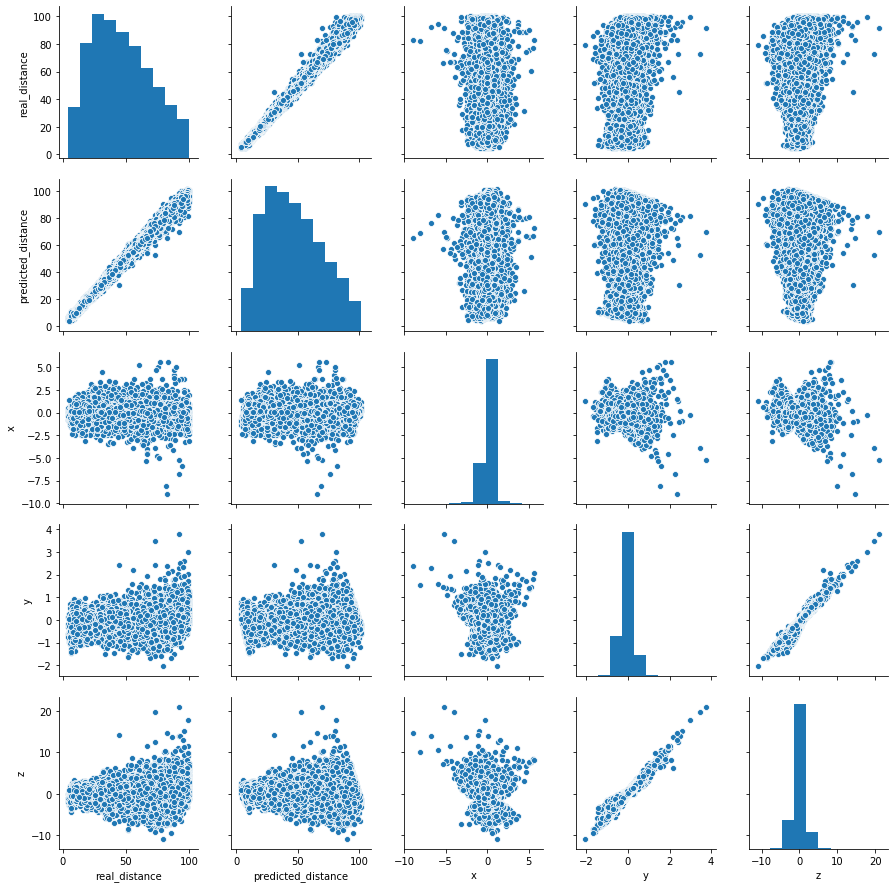

In [50]:
seaborn.pairplot(df)

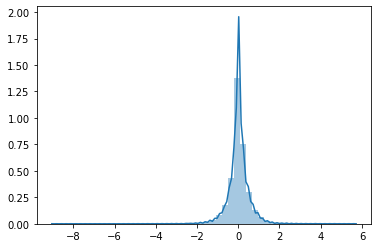

In [51]:
seaborn.distplot(dcoord_numpy[:,0])

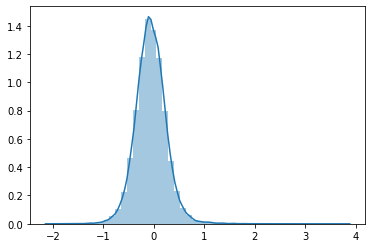

In [52]:
seaborn.distplot(dcoord_numpy[:,1])

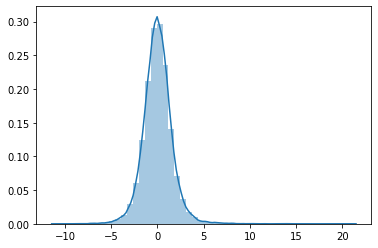

In [53]:
seaborn.distplot(dcoord_numpy[:,2])

In [ ]:
print(s)

torch.save(model.state_dict(), "model_1601_1500.pth")
torch.save(optimizer.state_dict(), "optim_1601_1500.pth")

plt.plot([l["cls_loss"] for l in losses], alpha=0.2) #second epoch lr =1e-4
plt.plot(smooth(0.1, [l["cls_loss"] for l in losses]))
plt.ylim((0,0.5))
plt.grid()

# lr = 0.0001
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim(0,30)
plt.grid()

# lr = 0.001
plt.plot([l["loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["loss"] for l in losses]))
plt.ylim((0,7))
plt.grid()

# lr = 0.001, LeakyReLU
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,30))
plt.grid()

# lr = 0.001, ReLU, xavier_normal + constant
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,30))
plt.grid()

# lr = 0.001, ReLU, kaiming_normal + constant
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,30))
plt.grid()

# lr = 0.001, LeakyReLU, kaiming_normal + constant
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,30))
plt.grid()

# lr = 0.001, LeakyReLU, kaiming_normal + constant
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,0.1))
plt.grid()

# lr = 1E-6, LeakyReLU, kaiming_normal + constant
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,0.1))
plt.grid()

torch.save(model.state_dict(), "scare_model.pth")
torch.save(optimizer.state_dict(), "scare_optim.pth")

batch['orientation']

outputs['orientation'] / torch.norm(outputs['orientation'], dim=-1, keepdim=True)

torch.sum(torch.abs(outputs['orientation'] / torch.norm(outputs['orientation'], dim=-1, keepdim=True) - batch['orientation']), dim=1)

torch.sum((outputs['orientation'] / torch.norm(outputs['orientation'], dim=-1, keepdim=True) - batch['orientation']) ** 2, dim=1) ** 0.5

batch['label']

torch.argmax(outputs['cls_score'], dim=1)

In [ ]:
model.backbone

nn.Sequential

import pandas as pd

df = pd.read_csv(C.TRAIN_CSV)

df.head()

import utils

train_anns = utils.load_train_annotations()

train_anns["ID_8a6e65317"]

orientations_euler = []
for k, v in train_anns.items():
    for y, p, r in zip(v["yaws"], v["pitches"], v["rolls"]):
        orientations_euler.append((-p, -y, -r))

len(orientations_euler)

from scipy.spatial.transform import rotation as R

euler_angles = self.gt["annotations"][idx][self.orientation_field]
rotation = R.from_euler("XYZ", euler_angles)
q = rotation.as_quat()

def quaternion_to_euler_angle(q):

    """Convert quaternion to euler angel.
    Input:
        q: 1 * 4 vector,
    Output:
        angle: 1 x 3 vector, each row is [roll, pitch, yaw]
    """
    w, x, y, z = q
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

def euler_angles_to_quaternions(angle):
    """Convert euler angels to quaternions representation.
    Input:
        angle: n x 3 matrix, each row is [roll, pitch, yaw]
    Output:
        q: n x 4 matrix, each row is corresponding quaternion.
    """

    in_dim = np.ndim(angle)
    if in_dim == 1:
        angle = angle[None, :]

    n = angle.shape[0]
    roll, pitch, yaw = angle[:, 0], angle[:, 1], angle[:, 2]
    q = np.zeros((n, 4))

    cy = np.cos(yaw * 0.5)
    sy = np.sin(yaw * 0.5)
    cr = np.cos(roll * 0.5)
    sr = np.sin(roll * 0.5)
    cp = np.cos(pitch * 0.5)
    sp = np.sin(pitch * 0.5)

    q[:, 0] = cy * cr * cp + sy * sr * sp
    q[:, 1] = cy * sr * cp - sy * cr * sp
    q[:, 2] = cy * cr * sp + sy * sr * cp
    q[:, 3] = sy * cr * cp - cy * sr * sp

    return q

orientations_euler = np.array(orientations_euler)

orientations_quat = euler_angles_to_quaternions(orientations_euler[:, ::-1])

orientations_quat[:30]

for q in orientations_quat[:100]:
    print(q)

orientations_quat[0]

((orientations_quat[2][1:] / np.sin(np.arccos(orientations_quat[2][0]))) ** 2).sum()

((orientations_quat[2][:-1] / np.sin(np.arccos(orientations_quat[2][-1]))) ** 2).sum()